In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from data import VISDRONEDetection, VISDRONEAnnotationTransform, VISDRONE_ROOT, BaseTransform
from data import VISDRONE_CLASSES as labelmap
import torch.utils.data as data
from models.refinedet import build_refinedet
import warnings
warnings.filterwarnings("ignore")
import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

# Build Refinedet in test phase

In [2]:
trained_model = './weights/RefineDet320_VISDRONE_final.pth'

In [3]:
net = build_refinedet('test', 320, 13)    # initialize SSD
net.load_state_dict(torch.load(trained_model))
net.eval()

passed # classes =  13


RefineDet(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d

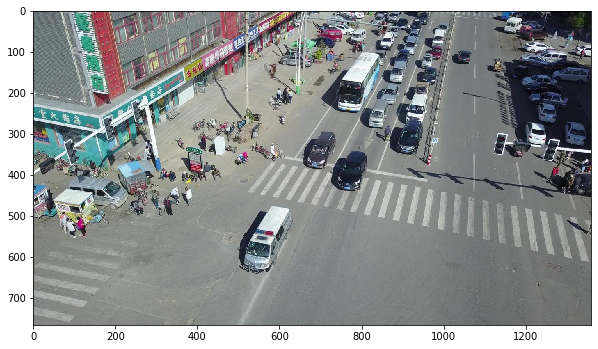

In [30]:
# testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
# dataset_mean = (104, 117, 123)
testset = VISDRONEDetection('val', None, VISDRONEAnnotationTransform())
img_id = 101
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


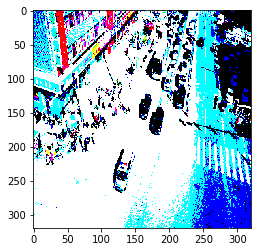

In [31]:
x = cv2.resize(image, (320, 320)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [32]:
xx = torch.unsqueeze(x, 0)
# if torch.cuda.is_available():
#     xx = xx.cuda()
y = net(xx)

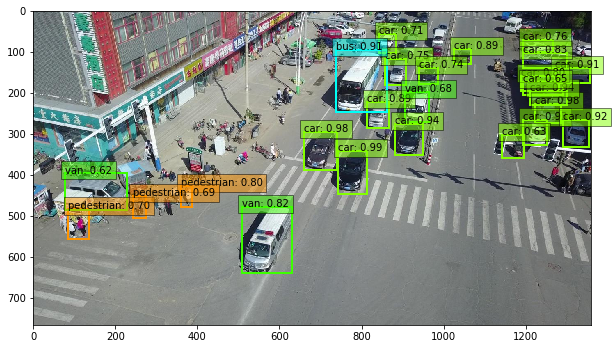

In [34]:
top_k=10
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labelmap[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1